In [2]:
import pandas as pd
import json
import dateutil.parser as dparser

# Levenshtein distance function
def levenshtein_distance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

# Function to calculate similarity scores between two annotations
def compute_similarity_scores(gpt_annotation_str, human_annotation_str):
    if not isinstance(gpt_annotation_str, str) or not isinstance(human_annotation_str, str):
        return {}

    try:
        gpt_annotation = json.loads(gpt_annotation_str)
        human_annotation = json.loads(human_annotation_str)
    except json.JSONDecodeError:
        return {}

    key_mapping = {}
    for gpt_key in gpt_annotation:
        mapped_key = min(human_annotation.keys(), key=lambda human_key: levenshtein_distance(gpt_key, human_key))
        key_mapping[gpt_key] = mapped_key

    scores = {}
    for gpt_key, human_key in key_mapping.items():
        gpt_value = gpt_annotation.get(gpt_key, "")
        human_value = human_annotation.get(human_key, "")
        
        if isinstance(gpt_value, list):
            gpt_value = ', '.join(map(str, gpt_value))
        if isinstance(human_value, list):
            human_value = ', '.join(map(str, human_value))
        
        if "Date" in gpt_key:
            try:
                gpt_date = dparser.parse(gpt_value, fuzzy=True).date()
                human_date = dparser.parse(human_value, fuzzy=True).date()
                scores[gpt_key] = 0 if gpt_date == human_date else 1
            except:
                scores[gpt_key] = levenshtein_distance(gpt_value, human_value)
        else:
            scores[gpt_key] = levenshtein_distance(gpt_value.lower(), human_value.lower())
    
    return scores

# Load CSV file
df = pd.read_csv('categories_atomic2.csv')

# Compute similarity scores
df_scores = df.apply(lambda row: compute_similarity_scores(row['gpt4_annotation'], row['human_annotation']), axis=1)
df_scores_df = pd.DataFrame(df_scores.tolist())
df_combined = pd.concat([df, df_scores_df], axis=1)

# Save to a new CSV file
df_combined.to_csv('categories_atomic2_with_scores2.csv', index=False)

print("Similarity scores computed and saved!")


Similarity scores computed and saved!


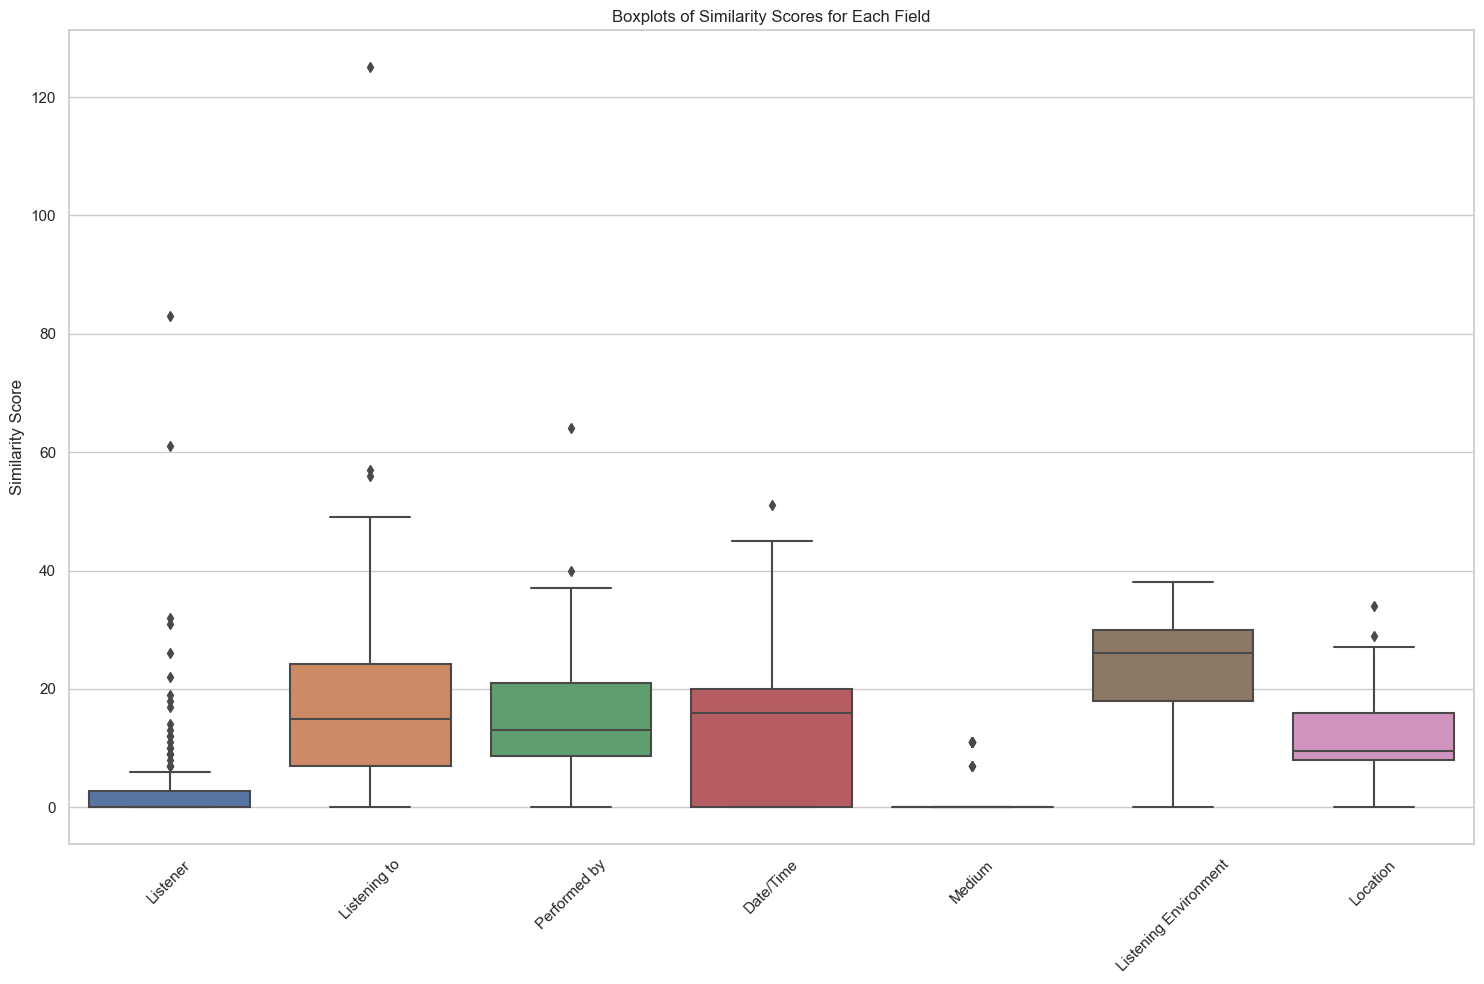

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df_scores = pd.read_csv('categories_atomic2_with_scores.csv')

# Extract columns corresponding to similarity scores
score_columns = [col for col in df_scores.columns if col not in ['URL', 'annotated_text', 'gpt4_annotation', 'human_annotation']]

# Set up the plot style
sns.set(style="whitegrid")

# Draw the boxplots
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_scores[score_columns])
plt.xticks(rotation=45)
plt.ylabel('Similarity Score')
plt.title('Boxplots of Similarity Scores for Each Field')
plt.tight_layout()
plt.show()
